# Score weak classifiers
## Import libraries

In [1]:
import pandas as pd
import re
from pathlib import Path
from constants import PROJECT_PATH, TOKENIZER_SUFFIXES
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from constants import PLOT_PATH
import matplotlib
colours = reversed(['#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255'])
matplotlib.rcParams['axes.prop_cycle'] = cycler('color', colours)

/home/jgut/miniconda3/envs/SMILES_OR_SELFIES/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jgut/miniconda3/envs/SMILES_OR_SELFIES/lib/python3.10/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


## Define useful classes

In [2]:
def get_cells(line:str)->[str]:
    return [cell.strip() for cell in re.split("  ", line) if len(cell)>0]

def get_report(path:Path):
    with open(path, "r") as file :
        lines = file.readlines()[:8]
    cells = [get_cells(line) for line in lines if len(line.strip())>0]
    out = {"estimator": cells[0][0], "0p":float(cells[1][1]), "0r":float(cells[1][2]), "0f":float(cells[1][3]), "1p":float(cells[2][1]), "1r":float(cells[2][2]), "1f":float(cells[2][3]), "accuracy": float(cells[3][1]), "Precision":float(cells[4][1]), "Recall":float(cells[4][2]), "F1":float(cells[4][3]), "wp":float(cells[5][1]), "wr":float(cells[5][2]), "wf":float(cells[5][3])}
    return out

def parse_tokenizer(tokenizer_string:str):
    """Parse tokenizer string

    Args:
        tokenizer_string (str): tokenizer string to parse

    Returns:
        Dict[str, str]: dictionary with tokenizer settings
    """
    tokenizer_parts = tokenizer_string.split("_")
    output = {
        "embedding": tokenizer_parts[0],
        "tokenizer": tokenizer_parts[1],
        "dataset": tokenizer_parts[2],
    }
    return output
interesting_rows = [['selfies', 'atom','standard','roberta'],['smiles', 'atom','standard','roberta'], ['selfies','atom','standard','bart'], ['smiles', 'atom','standard','bart'],]

## Compute dataframe

In [3]:
entries = []
for descriptor_name in ["Heterocycles", "NumHDonors"]:
    for tokenizer_suffix in TOKENIZER_SUFFIXES:
        for model in ["bart", "roberta"]:
            report_parent_path = PROJECT_PATH / f"embeddings_{model}" / descriptor_name / tokenizer_suffix / "reports"
            if not report_parent_path.exists():
                continue
            for estimators_file in report_parent_path.glob("*.txt"):
                entry = {"descriptor": descriptor_name, "architecture": model} | parse_tokenizer(tokenizer_suffix) | get_report(estimators_file)
                entries.append(entry)
df = pd.DataFrame(entries)
df

,descriptor,architecture,embedding,tokenizer,dataset,estimator,0p,0r,0f,1p,1r,1f,accuracy,Precision,Recall,F1,wp,wr,wf
0,Heterocycles,bart,smiles,atom,isomers,RBF SVC,0.96,0.98,0.97,0.98,0.96,0.97,0.97,0.97,0.97,0.97,0.97,0.97,0.97
1,Heterocycles,bart,smiles,atom,isomers,Linear SVC,0.93,0.95,0.94,0.95,0.93,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94
2,Heterocycles,bart,smiles,atom,isomers,KNN,0.82,0.94,0.88,0.93,0.80,0.86,0.87,0.88,0.87,0.87,0.88,0.87,0.87
3,Heterocycles,roberta,smiles,atom,isomers,RBF SVC,0.89,0.94,0.91,0.94,0.88,0.91,0.91,0.91,0.91,0.91,0.91,0.91,0.91
4,Heterocycles,roberta,smiles,atom,isomers,Logistic Regression,0.86,0.90,0.88,0.89,0.85,0.87,0.87,0.88,0.87,0.87,0.88,0.87,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,NumHDonors,bart,selfies,trained,standard,KNN,0.67,0.72,0.70,0.70,0.65,0.68,0.69,0.69,0.69,0.69,0.69,0.69,0.69
103,NumHDonors,roberta,selfies,trained,standard,RBF SVC,0.80,0.85,0.83,0.84,0.79,0.82,0.82,0.82,0.82,0.82,0.82,0.82,0.82
104,NumHDonors,roberta,selfies,trained,standard,Logistic Regression,0.77,0.79,0.78,0.78,0.76,0.77,0.78,0.78,0.78,0.78,0.78,0.78,0.78
105,NumHDonors,roberta,selfies,trained,standard,Linear SVC,0.72,0.87,0.79,0.83,0.66,0.74,0.77,0.78,0.77,0.76,0.78,0.77,0.76


In [4]:
full_pivot = pd.pivot_table(df[df.estimator != "Logistic Regression"], values=["accuracy"],index=["embedding","tokenizer","dataset","architecture"],columns=["descriptor","estimator"])
full_pivot[full_pivot.index.isin(interesting_rows)]["accuracy"]["Heterocycles"].values

array([[0.84, 0.91, 0.95],
       [0.82, 0.82, 0.9 ],
       [0.87, 0.94, 0.97],
       [0.81, 0.69, 0.91]])

## Diced by estimator

In [5]:
for estimator in df.estimator.unique():
    for descriptor in df.descriptor.unique(): 
        print(f"Estimator {estimator}, descriptor {descriptor}")
        display(df[["descriptor","embedding","tokenizer","dataset","estimator", "accuracy", "architecture"]][df.estimator==estimator][df.descriptor==descriptor].sort_values("accuracy"))
        print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))

Estimator RBF SVC, descriptor Heterocycles


/tmp/ipykernel_1846077/2218736018.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dataset","estimator", "accuracy", "architecture"]][df.estimator==estimator][df.descriptor==descriptor].sort_values("accuracy"))


,descriptor,embedding,tokenizer,dataset,estimator,accuracy,architecture
30,Heterocycles,selfies,atom,isomers,RBF SVC,0.88,roberta
36,Heterocycles,selfies,atom,standard,RBF SVC,0.90,roberta
42,Heterocycles,selfies,trained,isomers,RBF SVC,0.90,roberta
3,Heterocycles,smiles,atom,isomers,RBF SVC,0.91,roberta
10,Heterocycles,smiles,atom,standard,RBF SVC,0.91,roberta
45,Heterocycles,selfies,trained,standard,RBF SVC,0.91,bart
48,Heterocycles,selfies,trained,standard,RBF SVC,0.91,roberta
17,Heterocycles,smiles,trained,isomers,RBF SVC,0.92,roberta
39,Heterocycles,selfies,trained,isomers,RBF SVC,0.92,bart
24,Heterocycles,smiles,trained,standard,RBF SVC,0.94,roberta


\begin{tabular}{lllllllr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset & estimator & architecture &  accuracy \\
\midrule
0  &  Heterocycles &    smiles &      atom &   isomers &   RBF SVC &         bart &     0.970 \\
3  &  Heterocycles &    smiles &      atom &   isomers &   RBF SVC &      roberta &     0.910 \\
7  &  Heterocycles &    smiles &      atom &  standard &   RBF SVC &         bart &     0.970 \\
10 &  Heterocycles &    smiles &      atom &  standard &   RBF SVC &      roberta &     0.910 \\
14 &  Heterocycles &    smiles &   trained &   isomers &   RBF SVC &         bart &     0.960 \\
17 &  Heterocycles &    smiles &   trained &   isomers &   RBF SVC &      roberta &     0.920 \\
21 &  Heterocycles &    smiles &   trained &  standard &   RBF SVC &         bart &     0.960 \\
24 &  Heterocycles &    smiles &   trained &  standard &   RBF SVC &      roberta &     0.940 \\
27 &  Heterocycles &   selfies &      atom &   isomers &   RBF SVC &         bart &

/tmp/ipykernel_1846077/2218736018.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dat

,descriptor,embedding,tokenizer,dataset,estimator,accuracy,architecture
82,NumHDonors,selfies,atom,isomers,RBF SVC,0.76,roberta
89,NumHDonors,selfies,atom,standard,RBF SVC,0.79,roberta
96,NumHDonors,selfies,trained,isomers,RBF SVC,0.81,roberta
54,NumHDonors,smiles,atom,isomers,RBF SVC,0.82,roberta
61,NumHDonors,smiles,atom,standard,RBF SVC,0.82,roberta
103,NumHDonors,selfies,trained,standard,RBF SVC,0.82,roberta
100,NumHDonors,selfies,trained,standard,RBF SVC,0.84,bart
68,NumHDonors,smiles,trained,isomers,RBF SVC,0.85,roberta
93,NumHDonors,selfies,trained,isomers,RBF SVC,0.86,bart
79,NumHDonors,selfies,atom,isomers,RBF SVC,0.87,bart


\begin{tabular}{lllllllr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset & estimator & architecture &  accuracy \\
\midrule
51  &  NumHDonors &    smiles &      atom &   isomers &   RBF SVC &         bart &     0.920 \\
54  &  NumHDonors &    smiles &      atom &   isomers &   RBF SVC &      roberta &     0.820 \\
58  &  NumHDonors &    smiles &      atom &  standard &   RBF SVC &         bart &     0.910 \\
61  &  NumHDonors &    smiles &      atom &  standard &   RBF SVC &      roberta &     0.820 \\
65  &  NumHDonors &    smiles &   trained &   isomers &   RBF SVC &         bart &     0.930 \\
68  &  NumHDonors &    smiles &   trained &   isomers &   RBF SVC &      roberta &     0.850 \\
72  &  NumHDonors &    smiles &   trained &  standard &   RBF SVC &         bart &     0.920 \\
75  &  NumHDonors &    smiles &   trained &  standard &   RBF SVC &      roberta &     0.880 \\
79  &  NumHDonors &   selfies &      atom &   isomers &   RBF SVC &         bart &     0.870 

/tmp/ipykernel_1846077/2218736018.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dat

,descriptor,embedding,tokenizer,dataset,estimator,accuracy,architecture
12,Heterocycles,smiles,atom,standard,Linear SVC,0.69,roberta
37,Heterocycles,selfies,atom,standard,Linear SVC,0.82,roberta
31,Heterocycles,selfies,atom,isomers,Linear SVC,0.84,roberta
5,Heterocycles,smiles,atom,isomers,Linear SVC,0.85,roberta
43,Heterocycles,selfies,trained,isomers,Linear SVC,0.85,roberta
46,Heterocycles,selfies,trained,standard,Linear SVC,0.86,bart
19,Heterocycles,smiles,trained,isomers,Linear SVC,0.87,roberta
40,Heterocycles,selfies,trained,isomers,Linear SVC,0.87,bart
49,Heterocycles,selfies,trained,standard,Linear SVC,0.87,roberta
25,Heterocycles,smiles,trained,standard,Linear SVC,0.88,roberta


\begin{tabular}{lllllllr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  accuracy \\
\midrule
1  &  Heterocycles &    smiles &      atom &   isomers &  Linear SVC &         bart &     0.940 \\
5  &  Heterocycles &    smiles &      atom &   isomers &  Linear SVC &      roberta &     0.850 \\
8  &  Heterocycles &    smiles &      atom &  standard &  Linear SVC &         bart &     0.940 \\
12 &  Heterocycles &    smiles &      atom &  standard &  Linear SVC &      roberta &     0.690 \\
15 &  Heterocycles &    smiles &   trained &   isomers &  Linear SVC &         bart &     0.920 \\
19 &  Heterocycles &    smiles &   trained &   isomers &  Linear SVC &      roberta &     0.870 \\
22 &  Heterocycles &    smiles &   trained &  standard &  Linear SVC &         bart &     0.910 \\
25 &  Heterocycles &    smiles &   trained &  standard &  Linear SVC &      roberta &     0.880 \\
28 &  Heterocycles &   selfies &      atom &   isomers &  Linear 

/tmp/ipykernel_1846077/2218736018.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dat

,descriptor,embedding,tokenizer,dataset,estimator,accuracy,architecture
84,NumHDonors,selfies,atom,isomers,Linear SVC,0.63,roberta
63,NumHDonors,smiles,atom,standard,Linear SVC,0.67,roberta
91,NumHDonors,selfies,atom,standard,Linear SVC,0.68,roberta
56,NumHDonors,smiles,atom,isomers,Linear SVC,0.74,roberta
98,NumHDonors,selfies,trained,isomers,Linear SVC,0.75,roberta
105,NumHDonors,selfies,trained,standard,Linear SVC,0.77,roberta
70,NumHDonors,smiles,trained,isomers,Linear SVC,0.78,roberta
101,NumHDonors,selfies,trained,standard,Linear SVC,0.78,bart
94,NumHDonors,selfies,trained,isomers,Linear SVC,0.79,bart
80,NumHDonors,selfies,atom,isomers,Linear SVC,0.80,bart


\begin{tabular}{lllllllr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset &   estimator & architecture &  accuracy \\
\midrule
52  &  NumHDonors &    smiles &      atom &   isomers &  Linear SVC &         bart &     0.850 \\
56  &  NumHDonors &    smiles &      atom &   isomers &  Linear SVC &      roberta &     0.740 \\
59  &  NumHDonors &    smiles &      atom &  standard &  Linear SVC &         bart &     0.850 \\
63  &  NumHDonors &    smiles &      atom &  standard &  Linear SVC &      roberta &     0.670 \\
66  &  NumHDonors &    smiles &   trained &   isomers &  Linear SVC &         bart &     0.850 \\
70  &  NumHDonors &    smiles &   trained &   isomers &  Linear SVC &      roberta &     0.780 \\
73  &  NumHDonors &    smiles &   trained &  standard &  Linear SVC &         bart &     0.850 \\
77  &  NumHDonors &    smiles &   trained &  standard &  Linear SVC &      roberta &     0.810 \\
80  &  NumHDonors &   selfies &      atom &   isomers &  Linear SVC &      

/tmp/ipykernel_1846077/2218736018.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dat

,descriptor,embedding,tokenizer,dataset,estimator,accuracy,architecture
47,Heterocycles,selfies,trained,standard,KNN,0.78,bart
32,Heterocycles,selfies,atom,isomers,KNN,0.80,roberta
44,Heterocycles,selfies,trained,isomers,KNN,0.80,roberta
50,Heterocycles,selfies,trained,standard,KNN,0.80,roberta
13,Heterocycles,smiles,atom,standard,KNN,0.81,roberta
41,Heterocycles,selfies,trained,isomers,KNN,0.81,bart
6,Heterocycles,smiles,atom,isomers,KNN,0.82,roberta
38,Heterocycles,selfies,atom,standard,KNN,0.82,roberta
20,Heterocycles,smiles,trained,isomers,KNN,0.84,roberta
29,Heterocycles,selfies,atom,isomers,KNN,0.84,bart


\begin{tabular}{lllllllr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset & estimator & architecture &  accuracy \\
\midrule
2  &  Heterocycles &    smiles &      atom &   isomers &       KNN &         bart &     0.870 \\
6  &  Heterocycles &    smiles &      atom &   isomers &       KNN &      roberta &     0.820 \\
9  &  Heterocycles &    smiles &      atom &  standard &       KNN &         bart &     0.870 \\
13 &  Heterocycles &    smiles &      atom &  standard &       KNN &      roberta &     0.810 \\
16 &  Heterocycles &    smiles &   trained &   isomers &       KNN &         bart &     0.860 \\
20 &  Heterocycles &    smiles &   trained &   isomers &       KNN &      roberta &     0.840 \\
23 &  Heterocycles &    smiles &   trained &  standard &       KNN &         bart &     0.860 \\
26 &  Heterocycles &    smiles &   trained &  standard &       KNN &      roberta &     0.850 \\
29 &  Heterocycles &   selfies &      atom &   isomers &       KNN &         bart &

/tmp/ipykernel_1846077/2218736018.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dat

,descriptor,embedding,tokenizer,dataset,estimator,accuracy,architecture
85,NumHDonors,selfies,atom,isomers,KNN,0.65,roberta
99,NumHDonors,selfies,trained,isomers,KNN,0.65,roberta
106,NumHDonors,selfies,trained,standard,KNN,0.67,roberta
57,NumHDonors,smiles,atom,isomers,KNN,0.68,roberta
64,NumHDonors,smiles,atom,standard,KNN,0.68,roberta
78,NumHDonors,smiles,trained,standard,KNN,0.68,roberta
92,NumHDonors,selfies,atom,standard,KNN,0.68,roberta
95,NumHDonors,selfies,trained,isomers,KNN,0.69,bart
102,NumHDonors,selfies,trained,standard,KNN,0.69,bart
71,NumHDonors,smiles,trained,isomers,KNN,0.70,roberta


\begin{tabular}{lllllllr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset & estimator & architecture &  accuracy \\
\midrule
53  &  NumHDonors &    smiles &      atom &   isomers &       KNN &         bart &     0.760 \\
57  &  NumHDonors &    smiles &      atom &   isomers &       KNN &      roberta &     0.680 \\
60  &  NumHDonors &    smiles &      atom &  standard &       KNN &         bart &     0.750 \\
64  &  NumHDonors &    smiles &      atom &  standard &       KNN &      roberta &     0.680 \\
67  &  NumHDonors &    smiles &   trained &   isomers &       KNN &         bart &     0.740 \\
71  &  NumHDonors &    smiles &   trained &   isomers &       KNN &      roberta &     0.700 \\
74  &  NumHDonors &    smiles &   trained &  standard &       KNN &         bart &     0.740 \\
78  &  NumHDonors &    smiles &   trained &  standard &       KNN &      roberta &     0.680 \\
81  &  NumHDonors &   selfies &      atom &   isomers &       KNN &         bart &     0.700 

/tmp/ipykernel_1846077/2218736018.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dat

,descriptor,embedding,tokenizer,dataset,estimator,accuracy,architecture
11,Heterocycles,smiles,atom,standard,Logistic Regression,0.86,roberta
4,Heterocycles,smiles,atom,isomers,Logistic Regression,0.87,roberta
18,Heterocycles,smiles,trained,isomers,Logistic Regression,0.87,roberta


\begin{tabular}{lllllllr}
\toprule
{} &    descriptor & embedding & tokenizer &   dataset &            estimator & architecture &  accuracy \\
\midrule
4  &  Heterocycles &    smiles &      atom &   isomers &  Logistic Regression &      roberta &     0.870 \\
11 &  Heterocycles &    smiles &      atom &  standard &  Logistic Regression &      roberta &     0.860 \\
18 &  Heterocycles &    smiles &   trained &   isomers &  Logistic Regression &      roberta &     0.870 \\
\bottomrule
\end{tabular}

Estimator Logistic Regression, descriptor NumHDonors


/tmp/ipykernel_1846077/2218736018.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  display(df[["descriptor","embedding","tokenizer","dat

,descriptor,embedding,tokenizer,dataset,estimator,accuracy,architecture
83,NumHDonors,selfies,atom,isomers,Logistic Regression,0.71,roberta
90,NumHDonors,selfies,atom,standard,Logistic Regression,0.73,roberta
62,NumHDonors,smiles,atom,standard,Logistic Regression,0.74,roberta
55,NumHDonors,smiles,atom,isomers,Logistic Regression,0.76,roberta
97,NumHDonors,selfies,trained,isomers,Logistic Regression,0.76,roberta
104,NumHDonors,selfies,trained,standard,Logistic Regression,0.78,roberta
69,NumHDonors,smiles,trained,isomers,Logistic Regression,0.79,roberta
76,NumHDonors,smiles,trained,standard,Logistic Regression,0.82,roberta


\begin{tabular}{lllllllr}
\toprule
{} &  descriptor & embedding & tokenizer &   dataset &            estimator & architecture &  accuracy \\
\midrule
55  &  NumHDonors &    smiles &      atom &   isomers &  Logistic Regression &      roberta &     0.760 \\
62  &  NumHDonors &    smiles &      atom &  standard &  Logistic Regression &      roberta &     0.740 \\
69  &  NumHDonors &    smiles &   trained &   isomers &  Logistic Regression &      roberta &     0.790 \\
76  &  NumHDonors &    smiles &   trained &  standard &  Logistic Regression &      roberta &     0.820 \\
83  &  NumHDonors &   selfies &      atom &   isomers &  Logistic Regression &      roberta &     0.710 \\
90  &  NumHDonors &   selfies &      atom &  standard &  Logistic Regression &      roberta &     0.730 \\
97  &  NumHDonors &   selfies &   trained &   isomers &  Logistic Regression &      roberta &     0.760 \\
104 &  NumHDonors &   selfies &   trained &  standard &  Logistic Regression &      roberta &     0.7

/tmp/ipykernel_1846077/2218736018.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))
/tmp/ipykernel_1846077/2218736018.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df[["descriptor","embedding","tokenizer","dataset","estimator", "architecture", "accuracy"]][df.estimator==estimator][df.descriptor==descriptor].to_latex(float_format="%.3f"))


We see that for all of them, "atom" tokenizer performs better than "trained"/sentencepiece tokenizer and with a bigger impact SMILES performs better than SELFIES.

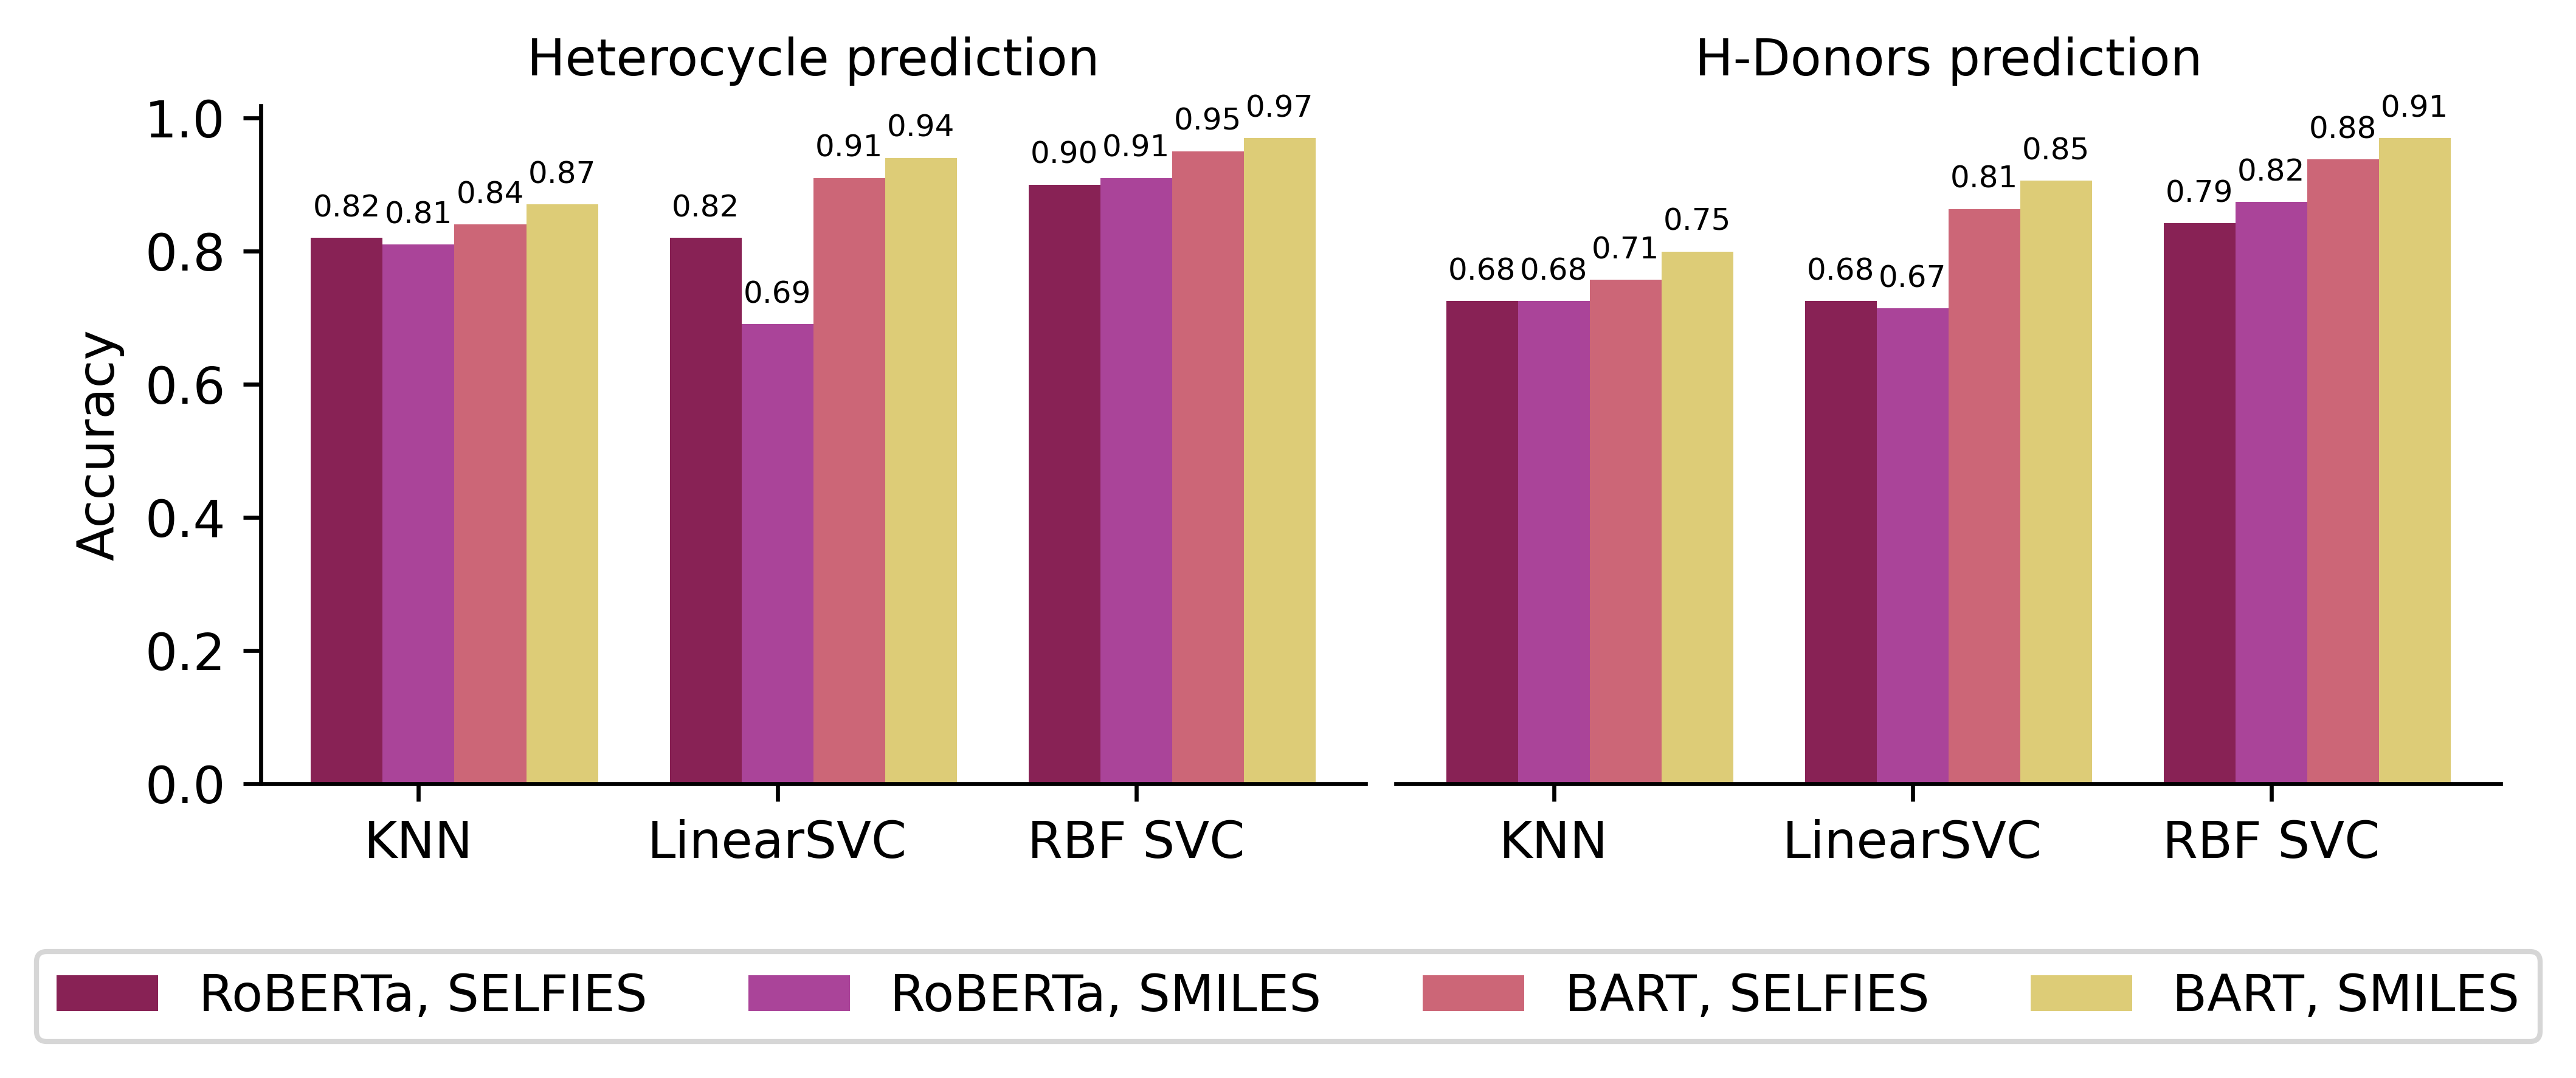

In [6]:
classifiers = ("KNN", "LinearSVC", "RBF SVC")
nice_rows = ["RoBERTa, SELFIES","RoBERTa, SMILES", "BART, SELFIES", "BART, SMILES",]
data_hetero = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["accuracy"]["Heterocycles"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
data_hdonor = {nice_rows[it]: vals for it, vals in enumerate(full_pivot[full_pivot.index.isin(interesting_rows)]["accuracy"]["NumHDonors"].sort_values(by=["architecture",'embedding'], ascending=[False,True]).values)}
datas = [data_hetero, data_hdonor]
x = np.arange(len(classifiers))  # the label locations
width = 0.2  # the width of the bars

cm = 1/2.54  # centimeters in inches
plt.rcParams['font.size'] = 10
fig, axs = plt.subplots(ncols=2, figsize=(17.1*cm, 6*cm), dpi=600, layout='constrained')
plt.rcParams['font.size'] = 6
for it, ax in enumerate(axs):
    data = datas[it]
    multiplier = 0
    for attribute, measurement in data.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3, fmt='%.2f')
        multiplier += 1
        if it == 0:
            ax.spines[['right', 'top', ]].set_visible(False)
            ax.set_ylabel('Accuracy')
            ax.set_title('Heterocycle prediction', fontsize=10)
        else:
            ax.spines[['right', 'top', "left"]].set_visible(False)
            ax.tick_params(left=[])
            ax.set_yticks([])
            ax.set_title('H-Donors prediction', fontsize=10)
        ax.set_xticks(x + width, classifiers)
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=4, fontsize=10)
plt.savefig(PLOT_PATH/'weak_classifiers.pdf', bbox_inches='tight',dpi=600, transparent=True)
plt.savefig(PLOT_PATH/'weak_classifiers.png', bbox_inches='tight',dpi=600, transparent=True)
plt.show()